# Задание

1) провести исследовательский анализ данных,
2) визуализировать результаты и сделать из них выводы,
3) провести предобработку признаков (возможно создать новые),
4) обучить модели, и подобрать для каждой из них оптимальные гиперпараметры,
5) оценить работу моделей и сравнить их между собой, выбрать итоговую и объяснить свой выбор,
6) проинтерпретировать получившиеся результаты (что и как влияет на LTV пользователя).

#### Устанавливаем пакеты, если они не установлены

In [ ]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install -U scikit-learn

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize
import warnings

warnings.filterwarnings('ignore')

#### Настроиваем формат вывода чисел float

In [2]:
pd.set_option('display.float_format', '{:_.2f}'.format)

## Загрузка данных
#### Загружаем датасет, пропуская сбойные строки

In [3]:
train_data = pd.read_csv('./LTV.csv', engine='python', on_bad_lines='skip')

#### Подсчет количества строк, столбцов

In [4]:
train_data.shape

(9134, 24)

#### Обзор данных

In [15]:
pd.set_option('display.max_columns', None)
train_data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2_763.52,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.81,Two-Door Car,Medsize
1,QZ44356,Arizona,6_979.54,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1_131.46,Four-Door Car,Medsize
2,AI49188,Nevada,12_887.43,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.47,Two-Door Car,Medsize
3,WW63253,California,7_645.86,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.88,SUV,Medsize
4,HB64268,Washington,2_813.69,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.13,Four-Door Car,Medsize


In [11]:
#pd.reset_option('display.max_columns')

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

#### Обзор пустых значений в столбцах

In [20]:
missing_values = train_data.isnull().sum(axis=0)
missing_values

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

#### Обзор дубликатов

In [18]:
duplicates = train_data.duplicated()
duplicates_train_data = train_data[duplicates]
duplicates_train_data

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size


#### Сводка по столбца и строкам, содержащие числа

In [21]:
description = train_data.describe()
description

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9_134.00,9_134.00,9_134.00,9_134.00,9_134.00,9_134.00,9_134.00,9_134.00
mean,8_004.94,37_657.38,93.22,15.10,48.06,0.38,2.97,434.09
std,6_870.97,30_379.90,34.41,10.07,27.91,0.91,2.39,290.50
min,1_898.01,0.00,61.00,0.00,0.00,0.00,1.00,0.10
25%,3_994.25,0.00,68.00,6.00,24.00,0.00,1.00,272.26
50%,5_780.18,33_889.50,83.00,14.00,48.00,0.00,2.00,383.95
75%,8_962.17,62_320.00,109.00,23.00,71.00,0.00,4.00,547.51
max,83_325.38,99_981.00,298.00,35.00,99.00,5.00,9.00,2_893.24


#### Выделим матрицу признаков и вектор с целевой переменной в тренировочной выборке

In [22]:
X = train_data.drop('Customer Lifetime Value', axis = 1)
y = pd.DataFrame(train_data['Customer Lifetime Value'])

#### Выделим численные признаки от остальных

In [23]:
num_cols = []
str_cols = []

cols_and_type = X.dtypes.to_dict()

for col in cols_and_type:
    if cols_and_type[col] in ('int64', 'float64'):
        num_cols.append(col)
    else: 
        str_cols.append(col)
        
print(num_cols)

['Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount']


In [24]:
cols_and_type

{'Customer': dtype('O'),
 'State': dtype('O'),
 'Response': dtype('O'),
 'Coverage': dtype('O'),
 'Education': dtype('O'),
 'Effective To Date': dtype('O'),
 'EmploymentStatus': dtype('O'),
 'Gender': dtype('O'),
 'Income': dtype('int64'),
 'Location Code': dtype('O'),
 'Marital Status': dtype('O'),
 'Monthly Premium Auto': dtype('int64'),
 'Months Since Last Claim': dtype('int64'),
 'Months Since Policy Inception': dtype('int64'),
 'Number of Open Complaints': dtype('int64'),
 'Number of Policies': dtype('int64'),
 'Policy Type': dtype('O'),
 'Policy': dtype('O'),
 'Renew Offer Type': dtype('O'),
 'Sales Channel': dtype('O'),
 'Total Claim Amount': dtype('float64'),
 'Vehicle Class': dtype('O'),
 'Vehicle Size': dtype('O')}

#### Создадим словарь признаков и их русский перевод

In [25]:
translate_col = {
'Customer': 'идентификатор пользователя',
'State': 'штат',
'Customer Lifetime Value': 'LTV пользователя',
'Response': 'взаимодействие с рекламой',
'Coverage': 'тип страхового покрытия',
'Education': 'образование',
'Effective To Date': 'срок действия страховки',
'EmploymentStatus': 'трудоустройство',
'Gender': 'пол',
'Income': 'доход',
'Location Code': 'тип местности в которой проживает пользователь',
'Marital Status': 'семейное положение',
'Monthly Premium Auto': 'Ежемесячный Премиум Авто',
'Months Since Last Claim': 'месяцев с последнего \n требования по выплате компенсации',
'Months Since Policy Inception': 'месяцев с открытия страховки',
'Number of Open Complaints': 'количество незакрытых жалоб',
'Number of Policies': 'количество полисов',
'Policy Type': 'тип страховки',
'Policy': 'страховка',
'Renew Offer Type': 'обновленный тип предложения',
'Sales Channel': 'канал продаж',
'Total Claim Amount': 'сумма выплаченных компенсаций',
'Vehicle Class': 'класс автомобиля',
'Vehicle Size': 'размер автомобиля'
}

# Выделим основные статистические показатели для числовых признаков:

• Customer Lifetime Value варьируется от 1898 до 83325.
• Средний доход (Income) составляет 37657.
• Средний месячный премиум по автострахованию (Monthly Premium Auto) составляет 93.
• Среднее количество месяцев с последней претензии (Months Since Last Claim) - 15.
• Среднее количество месяцев с начала страхования (Months Since Policy Inception) - 48.
• Среднее количество открытых жалоб (Number of Open Complaints) - 0.38.
• Среднее количество полисов (Number of Policies) - 2.97.
• Средняя сумма претензий (Total Claim Amount) - 434.

### Построим графики, посмотрим на распределение признаков
#### Визуализация распределения числовых признаков

In [29]:
# Устанавливаем стиль для графиков
sns.set(style="whitegrid")

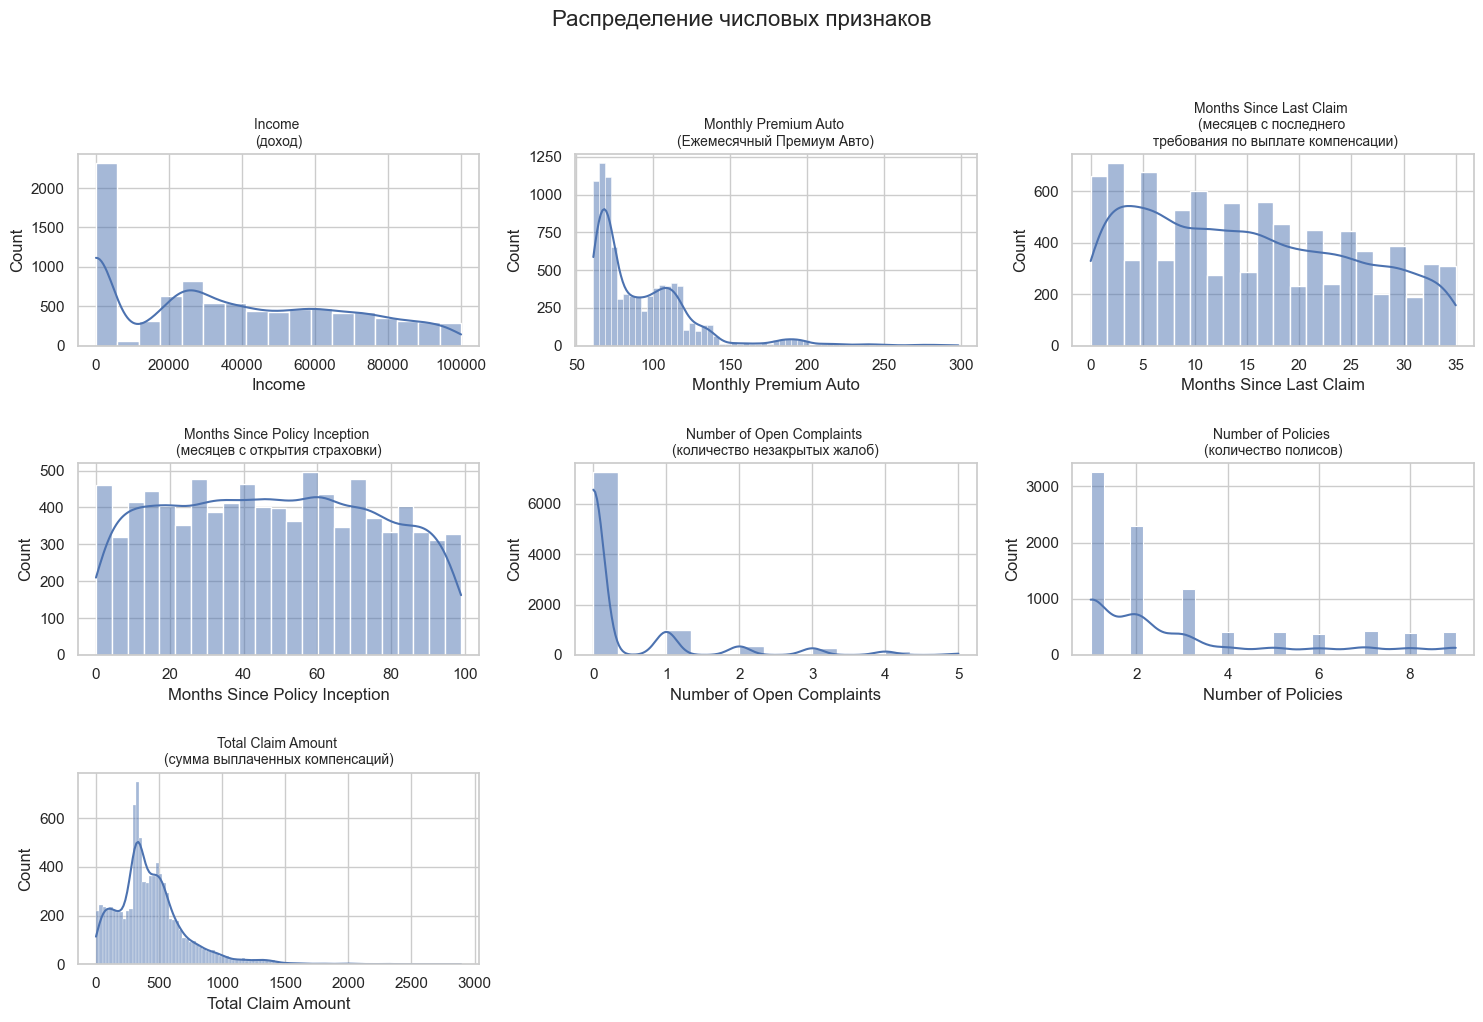

In [35]:
plt.figure(figsize=(15, 10))

# Генерация нескольких подграфиков
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_data[col], kde=True)
    plt.title(f'\n{col} \n({translate_col[col]})', fontsize=10)

# Общий заголовок для всех графиков
plt.suptitle('Распределение числовых признаков', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

#### Визуализация распределения целевой переменной

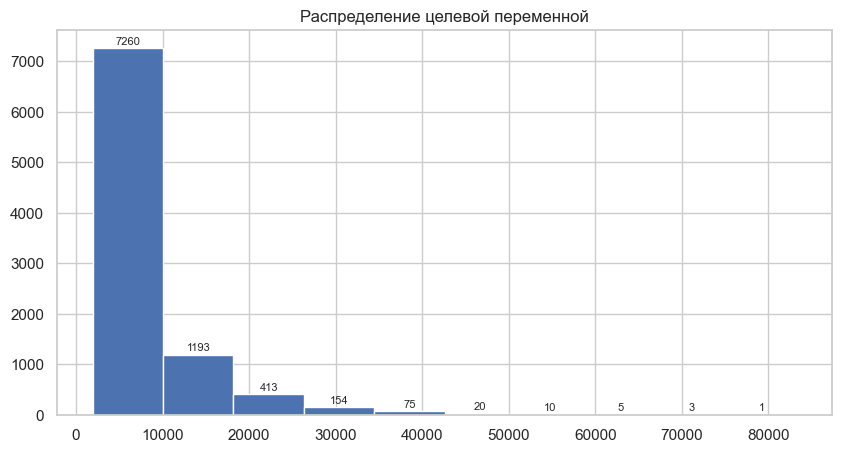

In [45]:
plt.figure(figsize=(10, 5))
plt.title('Распределение целевой переменной')
ax = train_data['Customer Lifetime Value'].hist()
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)

plt.show()

#### Визуализация распределения строковых признаков

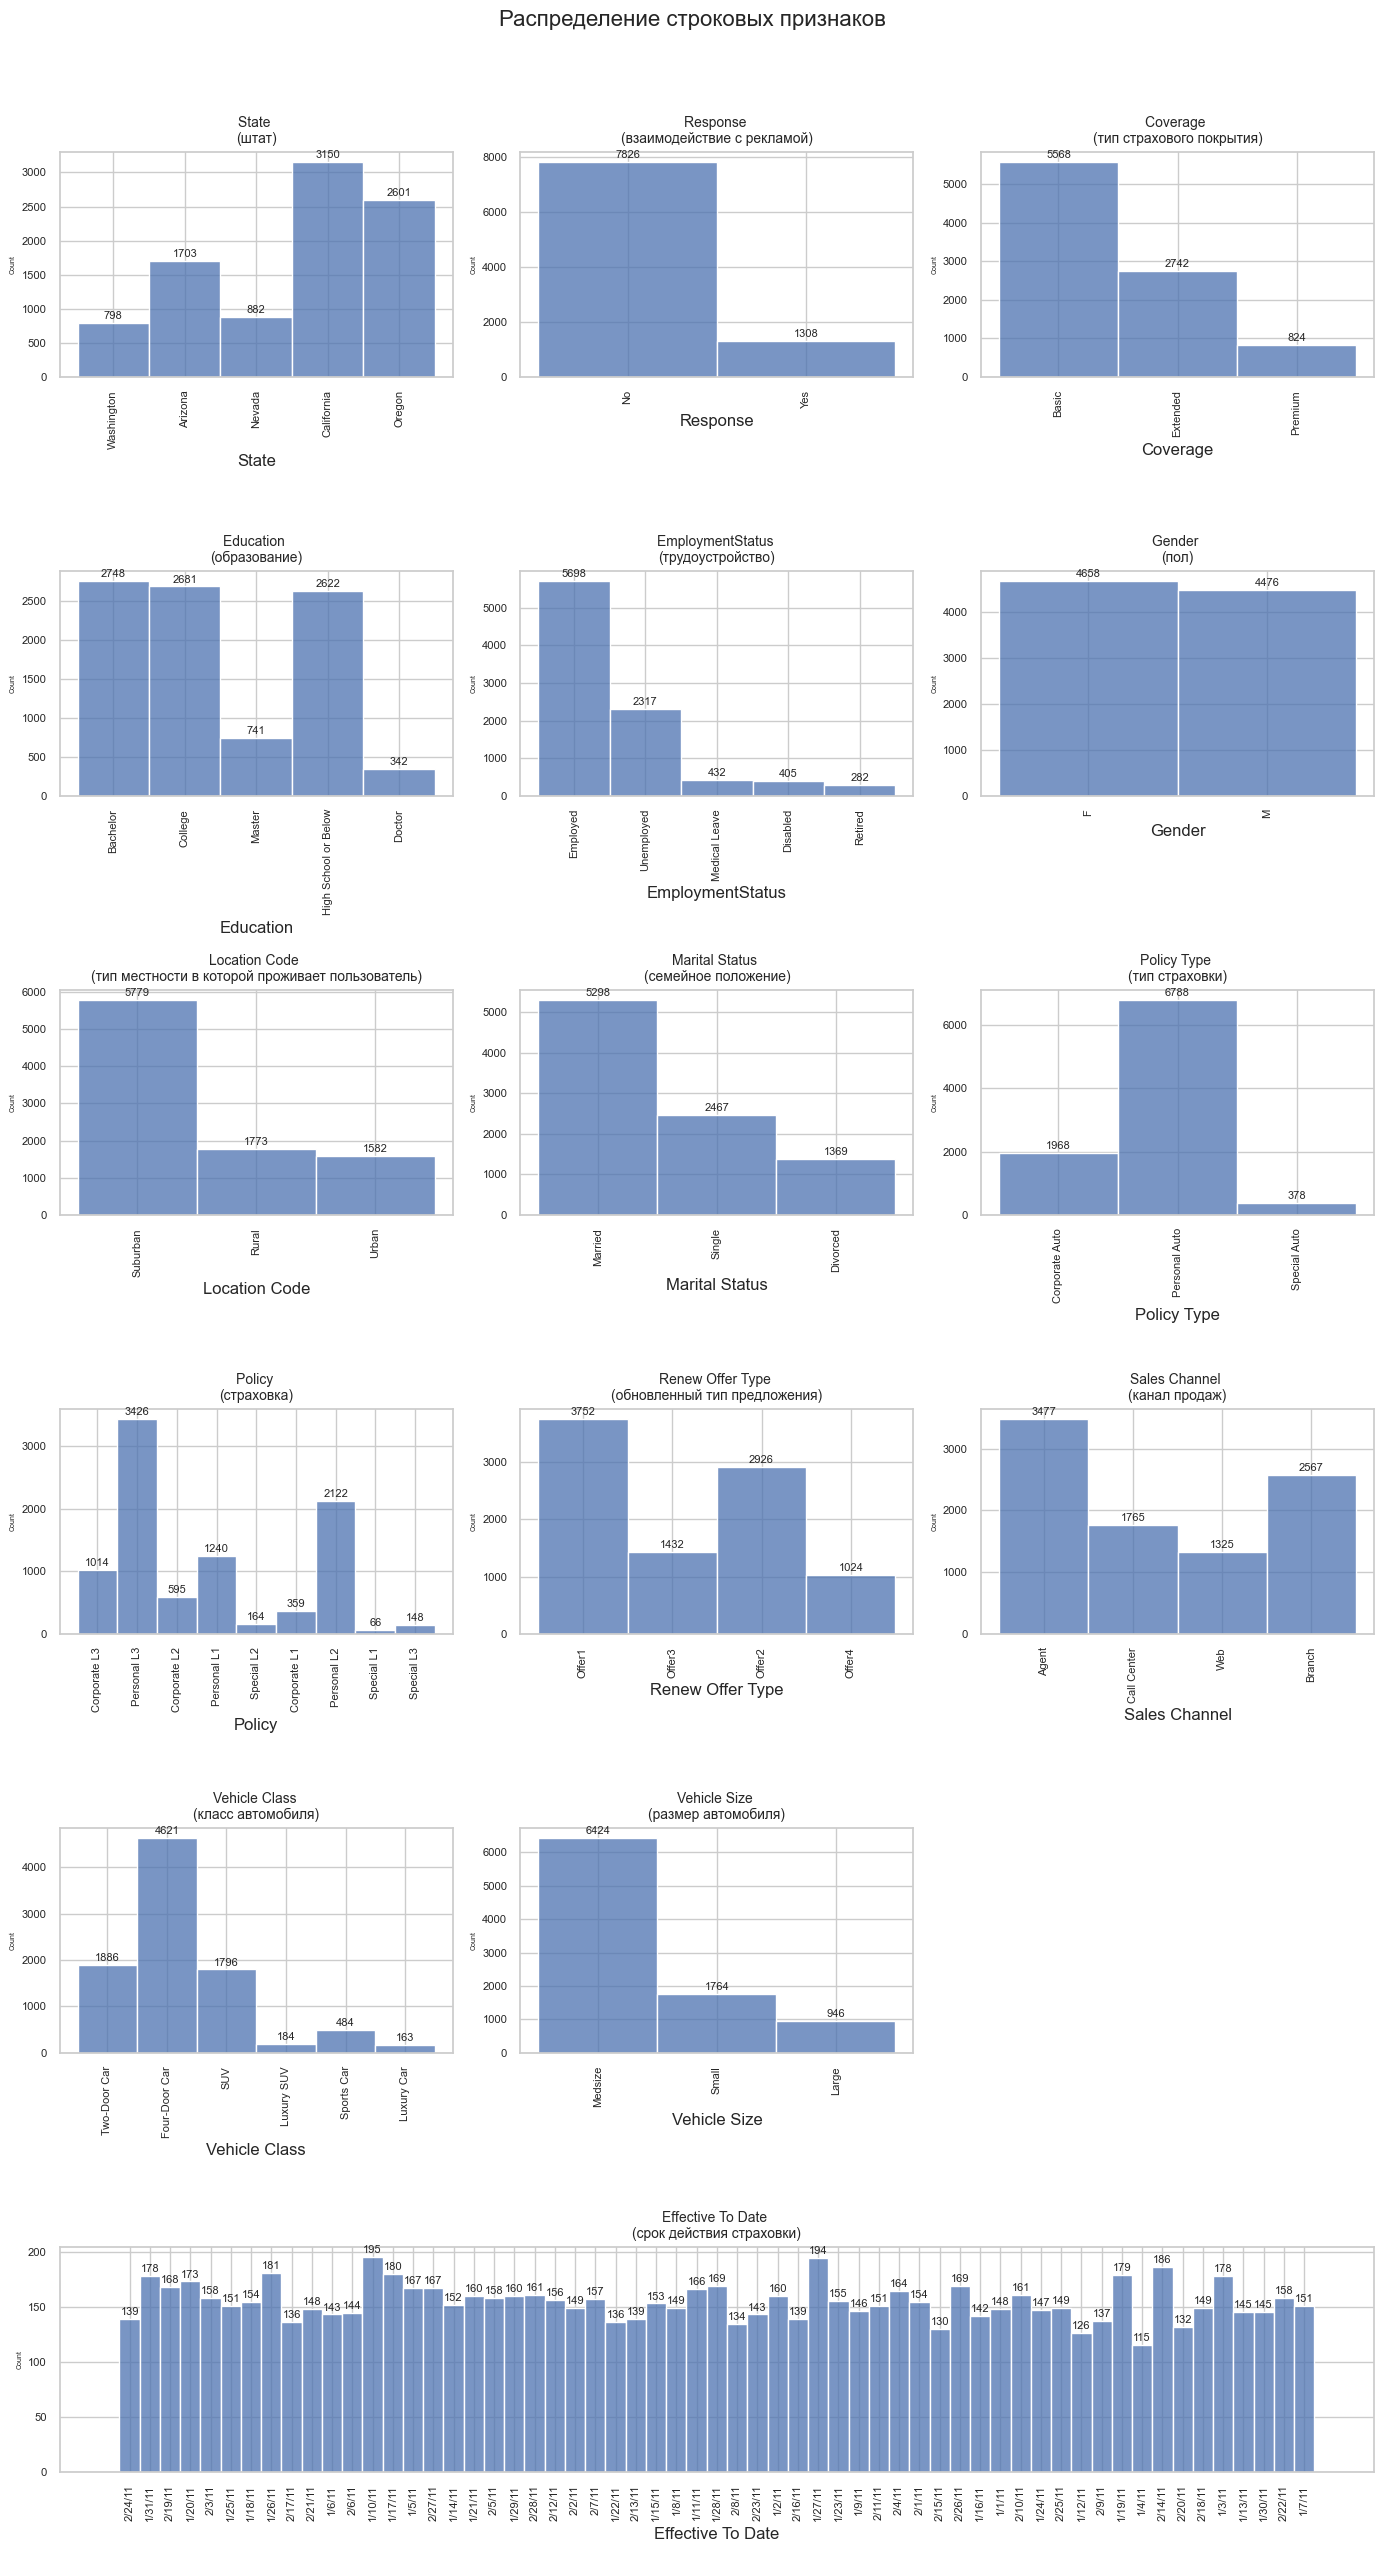

In [44]:
plt.figure(figsize=(14, 25))

index_plt = 1
for col in str_cols:
    if col not in ['Customer', 'Effective To Date']:
        plt.subplot(6, 3, index_plt)
        plt.title(f'{col} \n({translate_col[col]})', fontsize=10)
        plt.xticks(rotation=90, fontsize=8)
        plt.yticks(fontsize=8)
        plt.xlabel('')
        plt.ylabel('', fontsize=5)
        ax = sns.histplot(train_data[col])
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)
        index_plt += 1

plt.tight_layout()

plt.subplot(6, 1, 6)
plt.title(f'Effective To Date \n({translate_col["Effective To Date"]})', fontsize=10)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.ylabel('', fontsize=5)
ax = sns.histplot(train_data['Effective To Date'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)


# Общий заголовок для всех графиков
plt.suptitle('Распределение строковых признаков', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

## Предобработка признаков

#### Тестирование столбцов на выбросы методом расчета Z-score

In [59]:
def zscore_test(ds, col_test, threshold_val=3):
    '''
    Функция проводит тестирование столбцов на выбросы методом Z-score.
    
    :param ds: исследуемый датасет,
    :param col_test: список, колонок,
    :param threshold_val: пороговое значение Z-score,
    :return: результат исследования.
    '''
    result = ''
    for col in col_test:
        # Вычисление Z-score
        z = np.abs(stats.zscore(ds[col]))
        # Установка порогового значения Z-score
        threshold = 3
        # Выявление выбросов на основе Z-score
        outliers = ds[col][z > threshold]

        if len(outliers) > 0:
            result += f'В столбце {col}, {len(outliers)} выбросов. Среднее по столбцу {ds[col].mean()}\n'
    
    
    return 'Выбросов нет.' if result == '' else result


print(zscore_test(ds=X, col_test=num_cols))

В столбце Monthly Premium Auto, 63 выбросов. Среднее по столбцу 0.5247246098886665
В столбце Number of Open Complaints, 205 выбросов. Среднее по столбцу 0.38438800087584846
В столбце Total Claim Amount, 149 выбросов. Среднее по столбцу 0.5447612283737046



#### Уберём выбросы в выбранных признаках, с помощью логорифмической функции

In [60]:
X['Monthly Premium Auto'] = np.log1p(X['Monthly Premium Auto'])
X['Total Claim Amount'] = np.log1p(X['Total Claim Amount'])

# Выведем признаки, которые имеют выбросы
print(zscore_test(ds=X, col_test=num_cols))

В столбце Monthly Premium Auto, 61 выбросов. Среднее по столбцу 0.4218064318493098
В столбце Number of Open Complaints, 205 выбросов. Среднее по столбцу 0.38438800087584846
В столбце Total Claim Amount, 140 выбросов. Среднее по столбцу 0.43477942431860284



#### Посмотрим выбросы в целевой переменной

In [61]:
zscore_test(ds=y, col_test=['Customer Lifetime Value'])

'В столбце Customer Lifetime Value, 211 выбросов. Среднее по столбцу 8004.940474987081\n'

#### Удалим выбросы с помощью логорифмической функции

In [62]:
y['Customer Lifetime Value'] = np.log1p(y['Customer Lifetime Value'])
# Выведем признаки, которые имеют выбросы
zscore_test(ds=y, col_test=['Customer Lifetime Value'])

'В столбце Customer Lifetime Value, 32 выбросов. Среднее по столбцу 8.748753196029405\n'

#### Переведём строковые признаки в числовые

In [64]:
le = LabelEncoder()
# Пробежимся по столбцам датафрейма и преобразуем буквеное обозначение в цифровое
for col in str_cols:
    X[col] = le.fit_transform(X[col].astype(str))

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   int32  
 1   State                          9134 non-null   int32  
 2   Response                       9134 non-null   int32  
 3   Coverage                       9134 non-null   int32  
 4   Education                      9134 non-null   int32  
 5   Effective To Date              9134 non-null   int32  
 6   EmploymentStatus               9134 non-null   int32  
 7   Gender                         9134 non-null   int32  
 8   Income                         9134 non-null   int64  
 9   Location Code                  9134 non-null   int32  
 10  Marital Status                 9134 non-null   int32  
 11  Monthly Premium Auto           9134 non-null   float64
 12  Months Since Last Claim        9134 non-null   i

#### Посмотрим корреляцию признаков

In [73]:
corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 1)
corr_matrix[np.abs(corr_matrix)<0.3] = 0

# Укажем в настройках, чтобы отображались все столбцы
pd.set_option('display.max_columns', None)
corr_matrix

,Customer,State,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
Customer,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
State,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Response,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Coverage,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Education,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Effective To Date,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
EmploymentStatus,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-0.70,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Gender,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Income,0.00,0.00,0.00,0.00,0.00,0.00,-0.70,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.30,0.00,0.00
Location Code,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.00,0.00


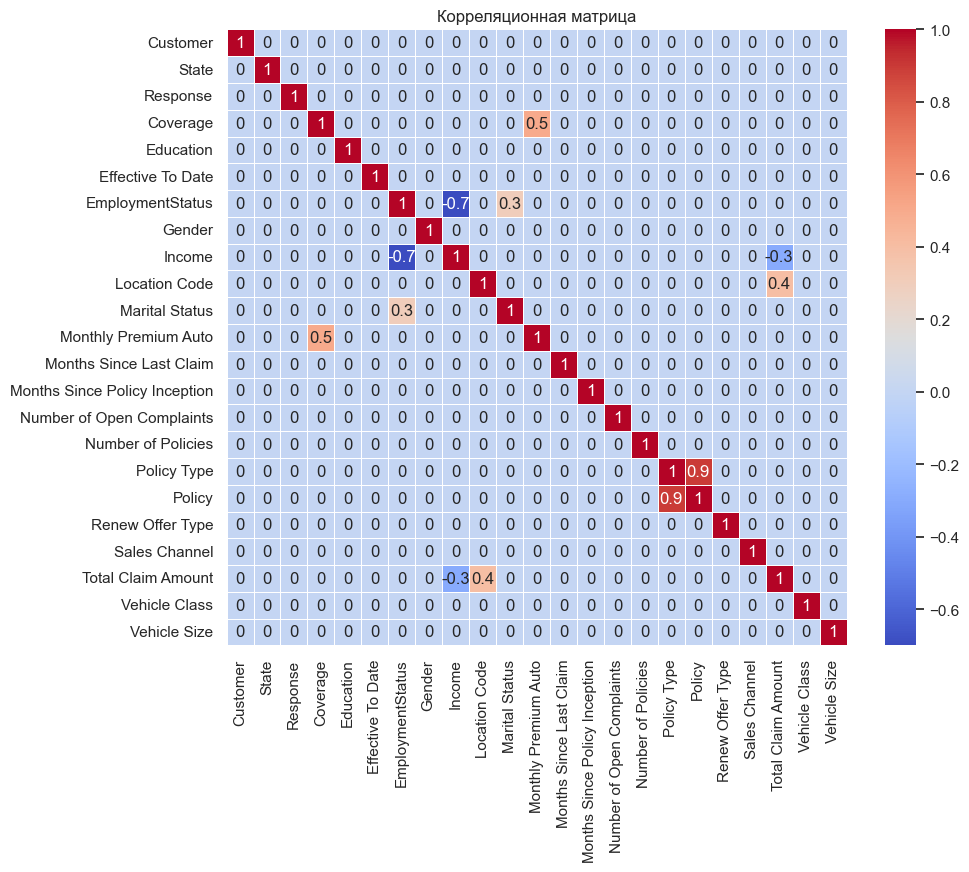

In [76]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

## Обучение различных моделей

Будем сравнивать между собой 4 модели: Линейная регрессию, Случайный лес, Градиентный бустинг, Лассо модель, Регрессия Байесовского хребта 

#### Линейная регрессия

In [78]:
from sklearn.linear_model import LinearRegression

# Выполняем кросс-валидацию для модели регрессии
from sklearn.model_selection import cross_validate

line_reg = LinearRegression()
cv_line_reg = cross_validate(line_reg, X, y, cv = 5)
print("Результат Линейной регрессии:", sum(cv_line_reg['test_score']) / len(cv_line_reg['test_score']))

Результат Линейной регрессии: 0.2594041127665879


#### Случайный лес

In [91]:
from sklearn.ensemble import RandomForestRegressor

# Создаем модель RandomForestRegressor
rf_reg_model = RandomForestRegressor()

# Выполняем кросс-валидацию для модели регрессии
cv_rf_reg = cross_validate(rf_reg_model, X, y, cv=5, scoring='r2')
print("Результат Случайного леса:", np.mean(cv_rf_reg['test_score']))


Результат Случайного леса: 0.9097888787316533


#### Градиентный бустинг

In [92]:
from sklearn.ensemble import GradientBoostingRegressor

# Создаем модель GradientBoostingRegressor
gb_reg_model = GradientBoostingRegressor()

# Выполняем кросс-валидацию для модели регрессии
cv_gb_reg = cross_validate(gb_reg_model, X, y, cv=5, scoring='r2')
print("Результат Градиентного бустинга:", np.mean(cv_gb_reg['test_score']))


Результат Градиентного бустинга: 0.9035285270748357


#### Лассо модель

In [84]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)

# Выполняем кросс-валидацию для модели регрессии
cv_lasso_reg = cross_validate(lasso_reg, X, y, cv = 5)
print("Результат Лассо регрессии:", sum(cv_line_reg['test_score']) / len(cv_line_reg['test_score']))

Результат Лассо регрессии: 0.2594041127665879


#### Регрессия Байесовского хребта 

In [95]:
from sklearn.linear_model import BayesianRidge

bayes_reg = BayesianRidge().fit(X, y)

#Выполняем кросс-валидацию для модели регрессии
cv_bayes_reg = cross_validate(bayes_reg, X, y, cv = 5)
print("Результат регрессии Байесовского хребта:", sum(cv_bayes_reg['test_score']) / len(cv_bayes_reg['test_score']))

Результат регрессии Байесовского хребта: 0.25938481973382627


In [97]:
# Пример предикта первой строчки датасета
np.expm1(bayes_reg.predict(np.array([X.iloc[0].values])))

array([4807.44595681])

### Вывод:  
Модели: Линейная регрессию, Лассо модель, Регрессия Байесовского хребта  показали одинаковый результат. Это может означать, что эти модели в данном случае не различаются в эффективности.

Удаление выбросов в целевой переменной y с помощью логарифмической функции привело к улучшению результатов. Это часто используется для улучшения качества моделей, особенно если данные имеют сильно скошенное распределение.

Модель регрессии Байесовского хребта (BayesianRidge) была выбрана для анализа. Пример показывает, как выполнить предсказание для первой строки датасета с использованием этой модели и как потом сделать обратное преобразование (от логарифмического преобразования к исходному значению).

Установка дополнительных параметров в моделях приводила только к ухудшению результатов. Это может свидетельствовать о том, что выбранные параметры уже оптимальны или что требуется более тщательная настройка параметров для достижения лучших результатов.

В целом, анализ проведенных экспериментов и результатов помогает понять, какие методы и подходы могут быть эффективными в вашей задаче и какие аспекты требуют дальнейшего исследования или улучшения.

## Интерпретация модели и важность признаков смотреть DZ5.1